In [1]:
#jupyter notebook --NotebookApp.max_buffer_size=4096

!pip install fuzzy-c-means
!pip install matplotlib
!pip install sklearn
!pip install scikit-learn-extra
!pip install graphviz

In [2]:
# ---
# jupyter:
#   jupytext:
#     formats: ipynb,py:percent
#     text_representation:
#       extension: .py
#       format_name: percent
#       format_version: '1.3'
#       jupytext_version: 1.13.8
#   kernelspec:
#     display_name: Python 3 (ipykernel)
#     language: python
#     name: python3
# ---

# %% [markdown]
# # Examples
#
# In this section we present some usage examples for MultiCons.
# We replicate the examples presented in the Thesis of Atheer Al-Najdi
# (A closed patterns-based approach to the consensus clustering problem).

# %% [markdown]
# ## Cassini dataset
#
# The dataset consists of 1000 instances, each represents a point in a 2D space,
# forming a structure of three clusters.
#
# As in the Thesis of Atheer Al-Najdi, we will try to cluster the dataset with 8
# different clustering algorithms and then compute and visualize the consensus
# clustering candidates using the MultiCons and ConsTree methods.
#
# **Let's get a first visual of the dataset and our base clusterings:**

# %%
from os import path

import numpy as np
import pandas as pd
from fcmeans import FCM
from matplotlib import pyplot as plt
from sklearn.cluster import (
    DBSCAN,
    AgglomerativeClustering,
    Birch,
    KMeans,
    SpectralClustering,
)
from sklearn.mixture import GaussianMixture
from sklearn_extra.cluster import KMedoids

from multicons import MultiCons
from multicons.utils import jaccard_similarity

np.set_printoptions(threshold=100)

In [3]:
# %%
# Load the data
file_prefix = "" if path.exists("cassini.csv") else "../multicons/docs/"
file_name = f"{file_prefix}cassini.csv"
cassini = pd.read_csv(file_name)
# Remove the class labels
cassini_train_data = cassini.drop(['class'], axis=1)

/var/folders/pr/63grnktj1ysd4sxbh42cz19r0000gn/T/ipykernel_55415/1286480827.py:71: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


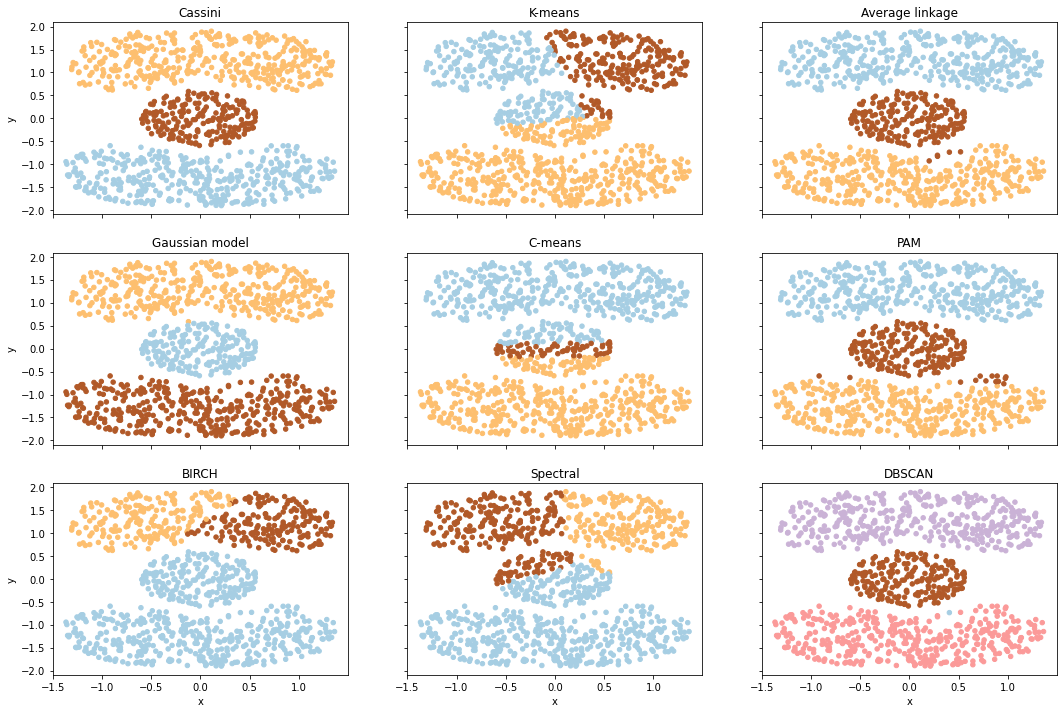

In [4]:
# %%
# Setup the plot axes
fig, axes = plt.subplots(
    nrows=3, ncols=3, figsize=(18, 12), sharex=True, sharey=True
)
# Common plot arguments
common_kwargs = {"x": "x", "y": "y", "colorbar": False, "colormap": "Paired"}
# Our collection of base clusterings
base_clusterings = []

# Cassini
cassini.plot.scatter(c="class", title="Cassini", ax=axes[0, 0], **common_kwargs)

# K-means
base_clusterings.append(KMeans(n_clusters=3).fit_predict(cassini_train_data))
cassini_train_data.plot.scatter(
    title="K-means", ax=axes[0, 1], c=base_clusterings[-1], **common_kwargs
)

# Average linkage
base_clusterings.append(
    AgglomerativeClustering(n_clusters=3).fit_predict(cassini_train_data)
)
cassini_train_data.plot.scatter(
    title="Average linkage", ax=axes[0, 2], c=base_clusterings[-1], **common_kwargs
)

# Gaussian model
base_clusterings.append(
    GaussianMixture(n_components=3, random_state=5).fit_predict(cassini_train_data)
)
cassini_train_data.plot.scatter(
    title="Gaussian model", ax=axes[1, 0], c=base_clusterings[-1], **common_kwargs
)

# C-means
fcm = FCM(n_clusters=3, max_iter=5, m=5)
fcm.fit(cassini_train_data.values)
base_clusterings.append(fcm.predict(cassini_train_data.values))
cassini_train_data.plot.scatter(
    title="C-means", ax=axes[1, 1], c=base_clusterings[-1], **common_kwargs
)

# PAM
base_clusterings.append(KMedoids(n_clusters=3).fit_predict(cassini_train_data))
cassini_train_data.plot.scatter(
    title="PAM", ax=axes[1, 2], c=base_clusterings[-1], **common_kwargs
)

# BIRCH
birch = Birch(n_clusters=3, threshold=0.5)
base_clusterings.append(birch.fit_predict(cassini_train_data))
cassini_train_data.plot.scatter(
    title="BIRCH", ax=axes[2, 0], c=base_clusterings[-1], **common_kwargs
)

# Spectral
base_clusterings.append(
    SpectralClustering(n_clusters=3).fit_predict(cassini_train_data)
)
cassini_train_data.plot.scatter(
    title="Spectral", ax=axes[2, 1], c=base_clusterings[-1], **common_kwargs
)

# DBSCAN
base_clusterings.append(DBSCAN(eps=0.2).fit_predict(cassini_train_data))
cassini_train_data.plot.scatter(
    title="DBSCAN", ax=axes[2, 2], c=base_clusterings[-1], **common_kwargs
)

fig.show()

In [5]:
# %% [markdown]
# At this point, `base_clusterings` now contains all clustering candidates in a list
# (of lists):

# %%
np.array(base_clusterings)

array([[1, 1, 1, ..., 1, 0, 1],
       [1, 1, 1, ..., 2, 2, 2],
       [2, 2, 2, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 2, 0],
       [0, 0, 0, ..., 2, 2, 2]])

In [6]:
# %% [markdown]
# > Note: This MultiCons implementation **requires** the clustering labels to be
# > **numerical**!

# %% [markdown]
# **Now, let's compute the consensus candidates with MultiCons:**

# %%
# MultiCons implementation aims to follow scikit-learn conventions.
consensus = MultiCons().fit(base_clusterings)
consensus

MultiCons(consensus_function=<function consensus_function_10 at 0x7fcf254b8310>,
          similarity_measure=<function jaccard_similarity at 0x7fcf2550aee0>)

In [7]:
# %%
# The `consensus_vectors` attribute is a python list containing the
# consensus candidates.
# We transform it to a numpy array to better visualize it here.
np.array(consensus.consensus_vectors)

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 2,  2,  2, ...,  0,  0,  0],
       [21, 12, 21, ..., 18, 17, 18]])

In [8]:
# %%
# The `decision_thresholds` attribute contains a list of decision thresholds
# for each consensus vector.
consensus.decision_thresholds

[4, 6, 7, 8]

In [9]:
# %%
# The `recommended` attribute contains the index of the recommended consensus
# vector
consensus.recommended

2

In [10]:
# %%
# The `labels_` attribute contains the recommended consensus vector
consensus.labels_

array([2, 2, 2, ..., 0, 0, 0])

/var/folders/pr/63grnktj1ysd4sxbh42cz19r0000gn/T/ipykernel_55415/3107033438.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


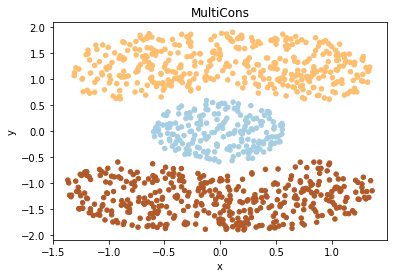

In [11]:
# %%
# Plot the recommended consensus clustering solution
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
cassini_train_data.plot.scatter(
    title="MultiCons", ax=axes, c=consensus.labels_, **common_kwargs
)
fig.show()

In [12]:
# %%
# The `stability` attribute contains a list of stability values
# for each consensus vector.
consensus.stability

[4, 2, 1, 1]

In [13]:
# %%
# The `tree_quality` member contains a measure of the tree quality.
# The measure ranges between 0 and 1. Higher is better.
consensus.tree_quality

0.625

In [14]:
# %%
# The `ensemble_similarity` contains a list of ensemble similarity measures
# for each consensus vector.
# They are between 0 and 1. Higher is better.
consensus.ensemble_similarity

array([0.38430731, 0.69130137, 0.78189399, 0.57951439])

In [15]:
import graphviz

def my_cons_tree(self) -> graphviz.Digraph:
        """Returns a ConsTree graph. Requires the `fit` method to be called first."""

        graph = graphviz.Digraph()
        graph.attr(
            "graph", label=f"ConsTree\nTree Quality = {self.tree_quality}", labelloc="t"
        )
        unique_count = [
            np.unique(vec, return_counts=True) for vec in self.consensus_vectors
        ]
        max_size = len(self.consensus_vectors[0])
        
        previous = []
        print(unique_count)
        for i, nodes_count in enumerate(unique_count):
            print('!!! ONE ST !!!', i, nodes_count)
            attributes = {
                "fillcolor": "slategray2",
                "shape": "ellipse",
                "style": "filled",
            }
            if i == self.recommended:
                attributes.update({"fillcolor": "darkseagreen", "shape": "box"})
            for j in range(len(nodes_count[0])):
                #print('!!! TWO ST!!!', i, j)
                node_id = f"{i}{nodes_count[0][j]}"
                attributes["width"] = str(int(9 * nodes_count[1][j] / max_size))
                graph.attr("node", **attributes)
                graph.node(node_id, str(nodes_count[1][j]))
                if i == 0:
                    continue
                for node in np.unique(
                    previous[self.consensus_vectors[i] == nodes_count[0][j]]
                ):
                    graph.edge(f"{i - 1}{node}", node_id)
                #print('!!! TWO END !!!', i, j)
                


            previous = self.consensus_vectors[i]
            with graph.subgraph(name="cluster") as sub_graph:
                sub_graph.attr("graph", label="Legend")
                sub_graph.attr("node", shape="box", width="")
                values = [
                    f"DT={self.decision_thresholds[i]}",
                    f"ST={self.stability[i]}",
                    f"Similarity={round(self.ensemble_similarity[i], 2)}",
                ]
                sub_graph.node(f"legend_{i}", " ".join(values))
                if i > 0:
                    sub_graph.edge(f"legend_{i-1}", f"legend_{i}")
            print('!!! ONE END !!!', i, nodes_count)
            
        print('DONE')
        return graph

!apt install graphviz

[(array([0]), array([1000])), (array([0, 1]), array([400, 600])), (array([0, 1, 2]), array([200, 400, 400])), (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21]), array([  1,   1,   1,   1,   2,   3,   5,   6,   7,   7,   8,  10,  12,
        12,  18,  19,  25,  47,  68, 174, 190, 383]))]
!!! ONE ST !!! 0 (array([0]), array([1000]))
!!! ONE END !!! 0 (array([0]), array([1000]))
!!! ONE ST !!! 1 (array([0, 1]), array([400, 600]))
!!! ONE END !!! 1 (array([0, 1]), array([400, 600]))
!!! ONE ST !!! 2 (array([0, 1, 2]), array([200, 400, 400]))
!!! ONE END !!! 2 (array([0, 1, 2]), array([200, 400, 400]))
!!! ONE ST !!! 3 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21]), array([  1,   1,   1,   1,   2,   3,   5,   6,   7,   7,   8,  10,  12,
        12,  18,  19,  25,  47,  68, 174, 190, 383]))
!!! ONE END !!! 3 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,

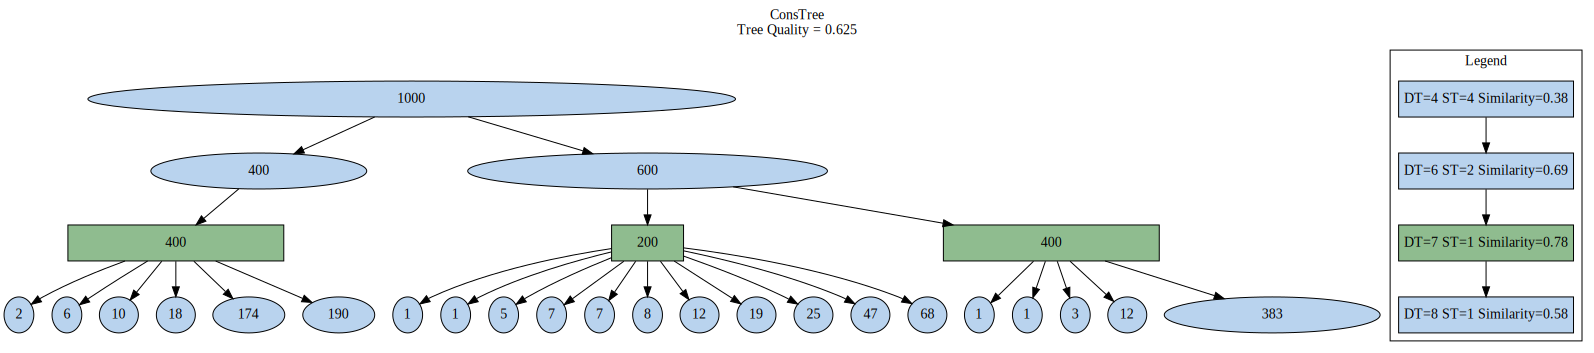

In [16]:
my_cons_tree(consensus)

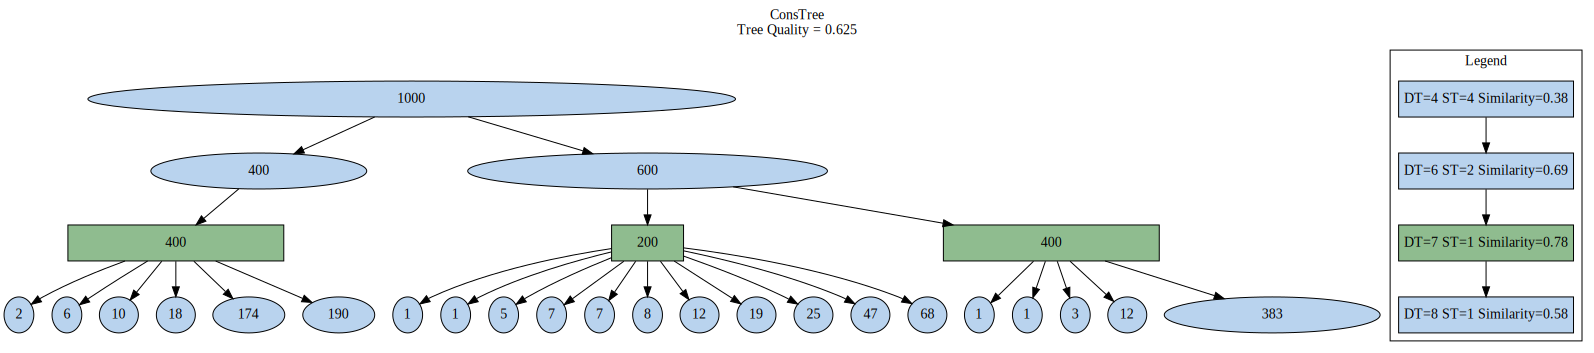

In [17]:
# %% [markdown]
# **Finally, let's visualize the consenus candidates using the ConsTree method:**

# %%
cons_tree = consensus.cons_tree()
cons_tree

In [18]:
# %%
# Save the ConsTree graph to a file
cons_tree.render(outfile=f"{file_prefix}CassiniConsTree.svg", cleanup=True)

'../multicons/docs/CassiniConsTree.svg'

/var/folders/pr/63grnktj1ysd4sxbh42cz19r0000gn/T/ipykernel_55415/478112027.py:49: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


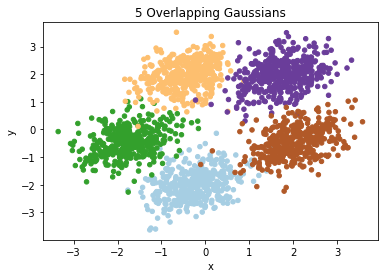

In [19]:
# %% [markdown]
# View ConsTree graph in full size: [CassiniConsTree.svg](../CassiniConsTree.svg)

# %% [markdown]
# ## 5 Overlapping Gaussian distributions
#
# Replicating the example with a synthetic dataset used in the thesis of Atheer
# that consist of:
# - generating 5 overlapping Gaussian distributed points in a 2D features space
# - appying 6 different clustering algorithms with random choices for K values
#     (in the range \[2, 9\])
# - comparing the results of 5 different MultiCons consensus solutions (by
#     altering the consensus functions)
#
# **Let's start by generating the dataset:**

# %%
cov = np.array([[0.3, 0.1], [0.1, 0.3]])
gaussian_distributions = pd.DataFrame(
    np.concatenate(
        (
            np.concatenate(
                (
                    np.random.multivariate_normal([-0.25, -2], cov, 400),
                    np.random.multivariate_normal([-1.75, -0.5], cov, 400),
                    np.random.multivariate_normal([-0.5, 2], cov, 400),
                    np.random.multivariate_normal([1.75, 2], cov, 400),
                    np.random.multivariate_normal([2, -0.5], cov, 400),
                ),
            ),
            np.concatenate(
                (
                    np.repeat([[1]], 400, 0),
                    np.repeat([[2]], 400, 0),
                    np.repeat([[3]], 400, 0),
                    np.repeat([[4]], 400, 0),
                    np.repeat([[5]], 400, 0),
                )
            )
        ),
        axis=1
    ),
    columns=["x", "y", "class"],
)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
gaussian_distributions.plot.scatter(
    title="5 Overlapping Gaussians", ax=axes, c="class", **common_kwargs
)
fig.show()

# %%
# Remove the class labels
gaussian_train_data = gaussian_distributions.drop(['class'], axis=1)

/var/folders/pr/63grnktj1ysd4sxbh42cz19r0000gn/T/ipykernel_55415/1521658995.py:74: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


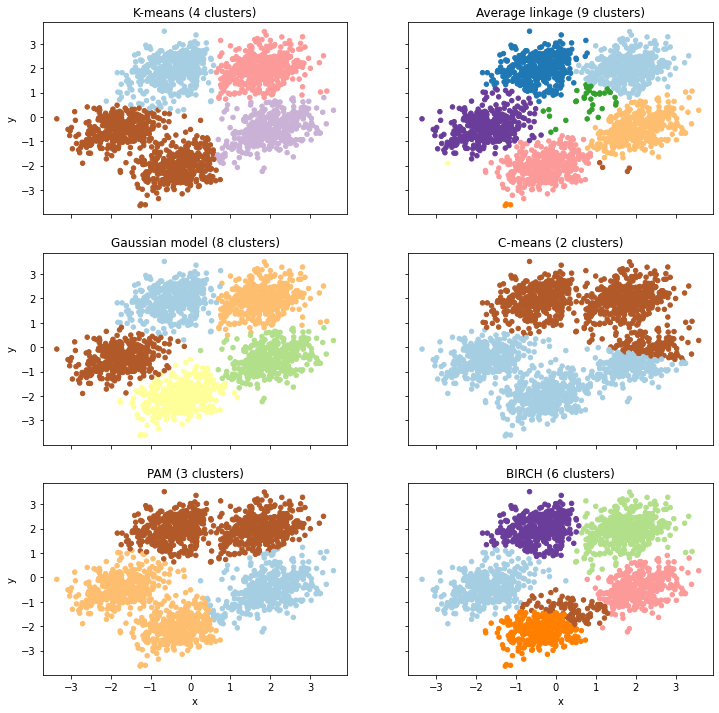

In [20]:
# %% [markdown]
# **Next, let's compute the base clusterings and visualize their outcome:**

# %%
# Setup the plot axes
fig, axes = plt.subplots(
    nrows=3, ncols=2, figsize=(12, 12), sharex=True, sharey=True
)
# Our collection of base clusterings
base_clusterings = []

# K-means (4 clusters)
base_clusterings.append(KMeans(n_clusters=4).fit_predict(gaussian_train_data))
gaussian_train_data.plot.scatter(
    title="K-means (4 clusters)",
    ax=axes[0, 0],
    c=base_clusterings[-1],
    **common_kwargs
)

# Average linkage (9 clusters)
base_clusterings.append(
    AgglomerativeClustering(n_clusters=9, linkage="average").fit_predict(
        gaussian_train_data
    )
)
gaussian_train_data.plot.scatter(
    title="Average linkage (9 clusters)",
    ax=axes[0, 1],
    c=base_clusterings[-1],
    **common_kwargs
)

# Gaussian model (8 clusters)
base_clusterings.append(
    GaussianMixture(n_components=8, random_state=2, reg_covar=0.2).fit_predict(
        gaussian_train_data
    )
)
gaussian_train_data.plot.scatter(
    title="Gaussian model (8 clusters)",
    ax=axes[1, 0],
    c=base_clusterings[-1],
    **common_kwargs
)

# C-means (2 clusters)
fcm = FCM(n_clusters=2, max_iter=5, m=5)
fcm.fit(gaussian_train_data.values)
base_clusterings.append(fcm.predict(gaussian_train_data.values))
gaussian_train_data.plot.scatter(
    title="C-means (2 clusters)",
    ax=axes[1, 1],
    c=base_clusterings[-1],
    **common_kwargs
)

# PAM (3 clusters)
base_clusterings.append(KMedoids(n_clusters=3).fit_predict(gaussian_train_data))
gaussian_train_data.plot.scatter(
    title="PAM (3 clusters)", ax=axes[2, 0], c=base_clusterings[-1], **common_kwargs
)

# BIRCH (5 clusters)
birch = Birch(n_clusters=6, threshold=0.5)
base_clusterings.append(birch.fit_predict(gaussian_train_data))
gaussian_train_data.plot.scatter(
    title="BIRCH (6 clusters)",
    ax=axes[2, 1],
    c=base_clusterings[-1],
    **common_kwargs
)

fig.show()

/var/folders/pr/63grnktj1ysd4sxbh42cz19r0000gn/T/ipykernel_55415/2612630259.py:50: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


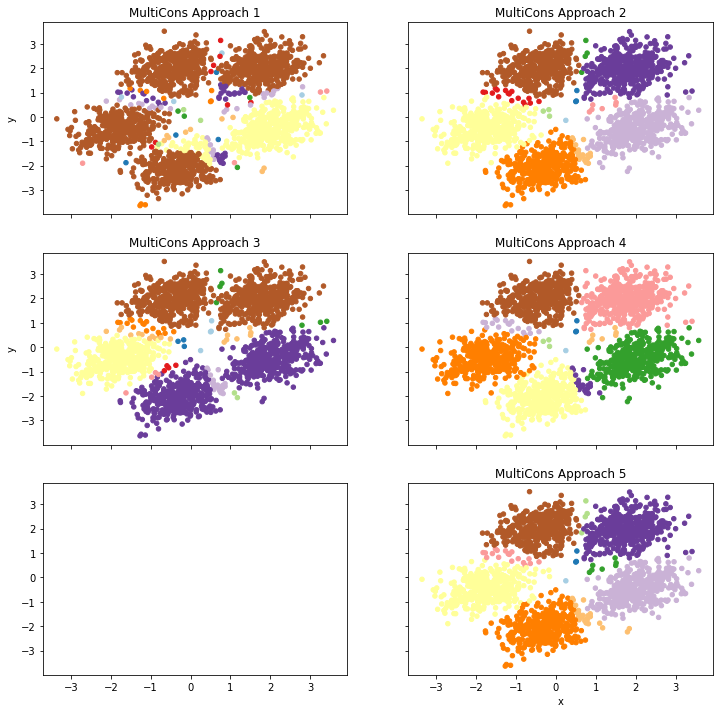

In [21]:
# %% [markdown]
# **Now, let's compute the consensus candidates with MultiCons and visualize their
# outcome:**

# %%
consensus_1 = MultiCons()
consensus_2 = MultiCons(consensus_function="consensus_function_12")
consensus_3 = MultiCons(consensus_function="consensus_function_13")
consensus_4 = MultiCons(consensus_function="consensus_function_14")
consensus_5 = MultiCons(consensus_function="consensus_function_15")

consensus_1.fit(base_clusterings)
consensus_2.fit(base_clusterings)
consensus_3.fit(base_clusterings)
consensus_4.fit(base_clusterings)
consensus_5.fit(base_clusterings)

# Plot the recommended consensus clustering solutions
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12), sharex=True, sharey=True)
gaussian_train_data.plot.scatter(
    title="MultiCons Approach 1",
    ax=axes[0, 0],
    c=consensus_1.labels_,
    **common_kwargs
)
gaussian_train_data.plot.scatter(
    title="MultiCons Approach 2",
    ax=axes[0, 1],
    c=consensus_2.labels_,
    **common_kwargs
)
gaussian_train_data.plot.scatter(
    title="MultiCons Approach 3",
    ax=axes[1, 0],
    c=consensus_3.labels_,
    **common_kwargs
)
gaussian_train_data.plot.scatter(
    title="MultiCons Approach 4",
    ax=axes[1, 1],
    c=consensus_4.labels_,
    **common_kwargs
)
gaussian_train_data.plot.scatter(
    title="MultiCons Approach 5",
    ax=axes[2, 1],
    c=consensus_5.labels_,
    **common_kwargs
)
fig.show()

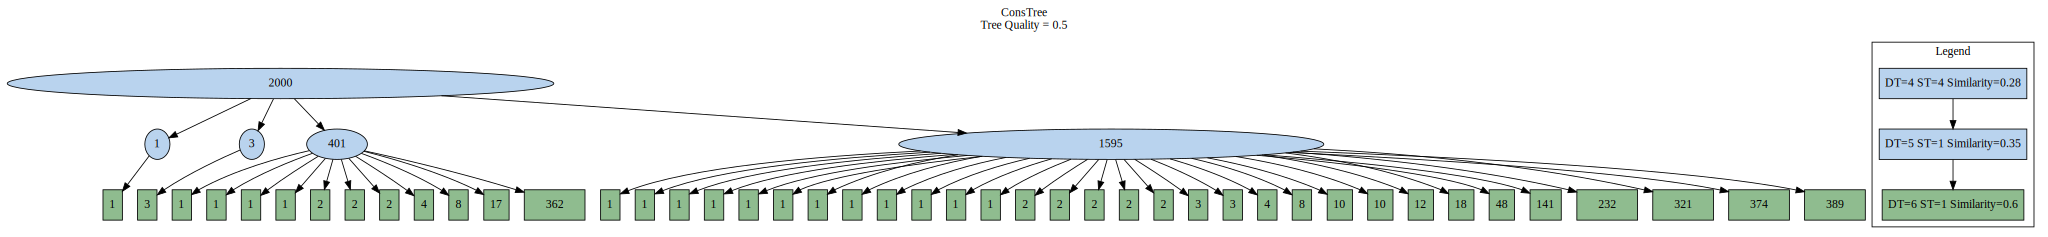

In [22]:
# %% [markdown]
# **Also, let's visualize the ConsTrees:**

# %%
cons_tree = consensus_1.cons_tree()
# Save the ConsTree graph to a file
cons_tree.render(outfile=f"{file_prefix}GaussianConsTree1.svg", cleanup=True)
cons_tree

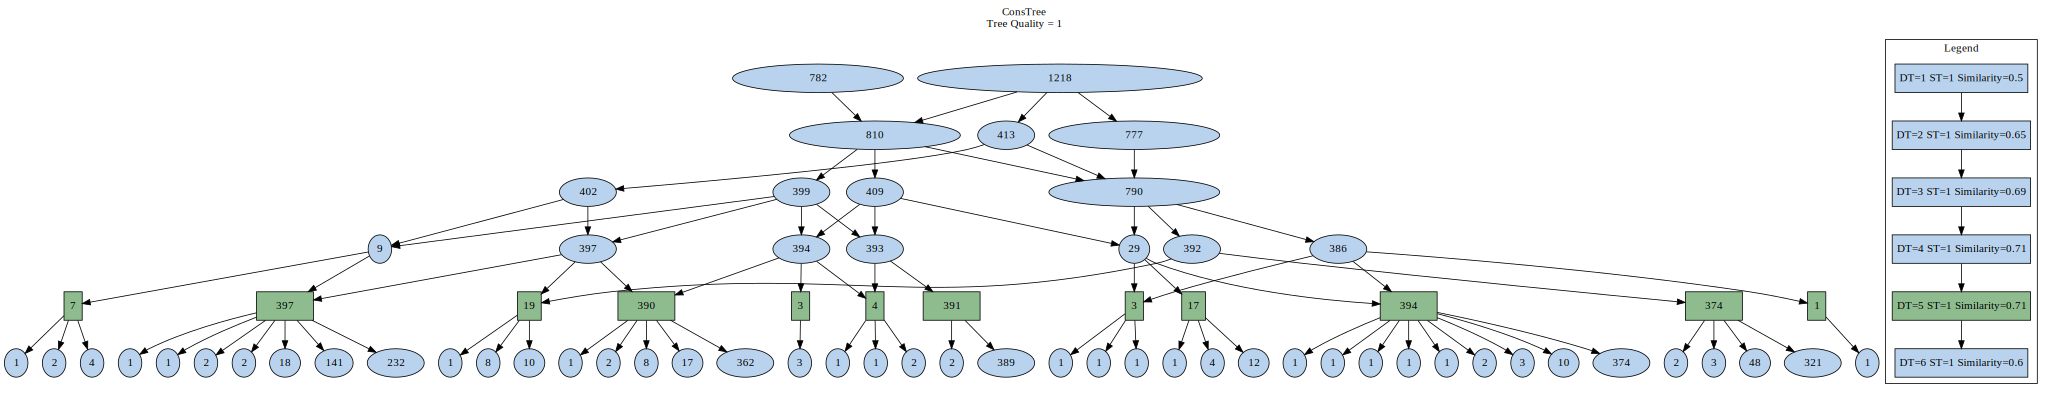

In [23]:
# %% [markdown]
# View ConsTree graph 1 in full size: [GaussianConsTree1.svg](../GaussianConsTree1.svg)

# %%
cons_tree = consensus_2.cons_tree()
# Save the ConsTree graph to a file
cons_tree.render(outfile=f"{file_prefix}GaussianConsTree2.svg", cleanup=True)
cons_tree

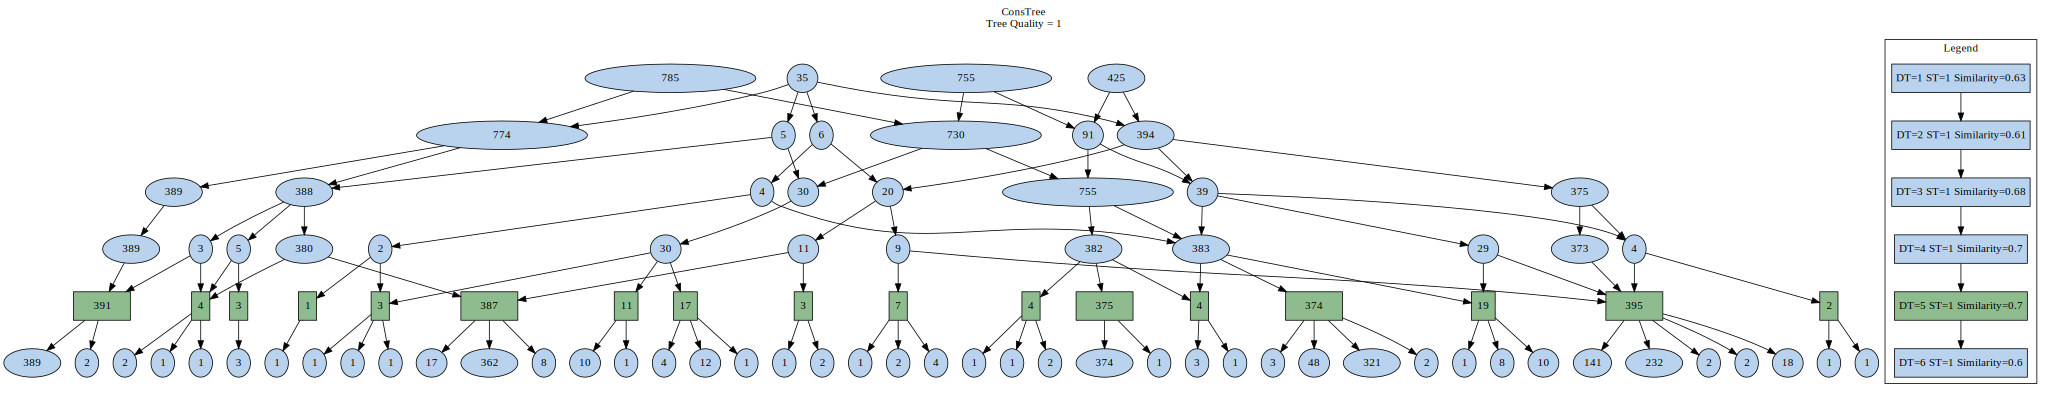

In [24]:
# %% [markdown]
# View ConsTree graph 2 in full size: [GaussianConsTree2.svg](../GaussianConsTree2.svg)

# %%
cons_tree = consensus_3.cons_tree()
# Save the ConsTree graph to a file
cons_tree.render(outfile=f"{file_prefix}GaussianConsTree3.svg", cleanup=True)
cons_tree

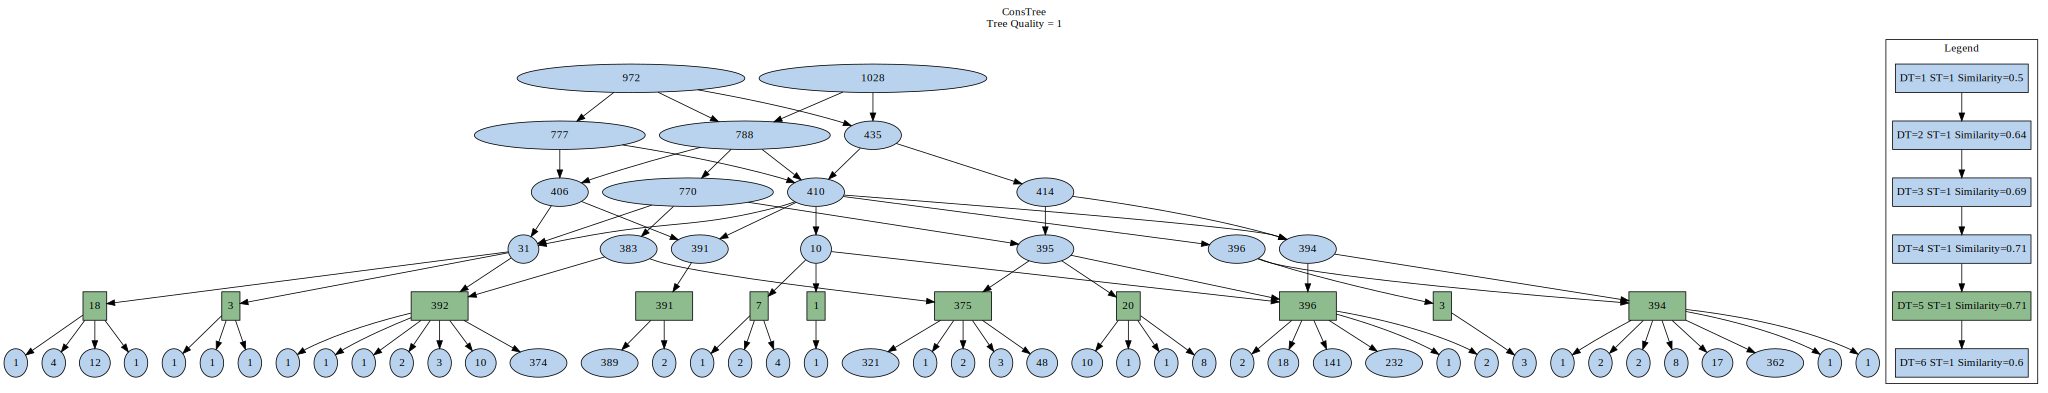

In [25]:
# %% [markdown]
# View ConsTree graph 1 in full size: [GaussianConsTree3.svg](../GaussianConsTree3.svg)

# %%
cons_tree = consensus_4.cons_tree()
# Save the ConsTree graph to a file
cons_tree.render(outfile=f"{file_prefix}GaussianConsTree4.svg", cleanup=True)
cons_tree

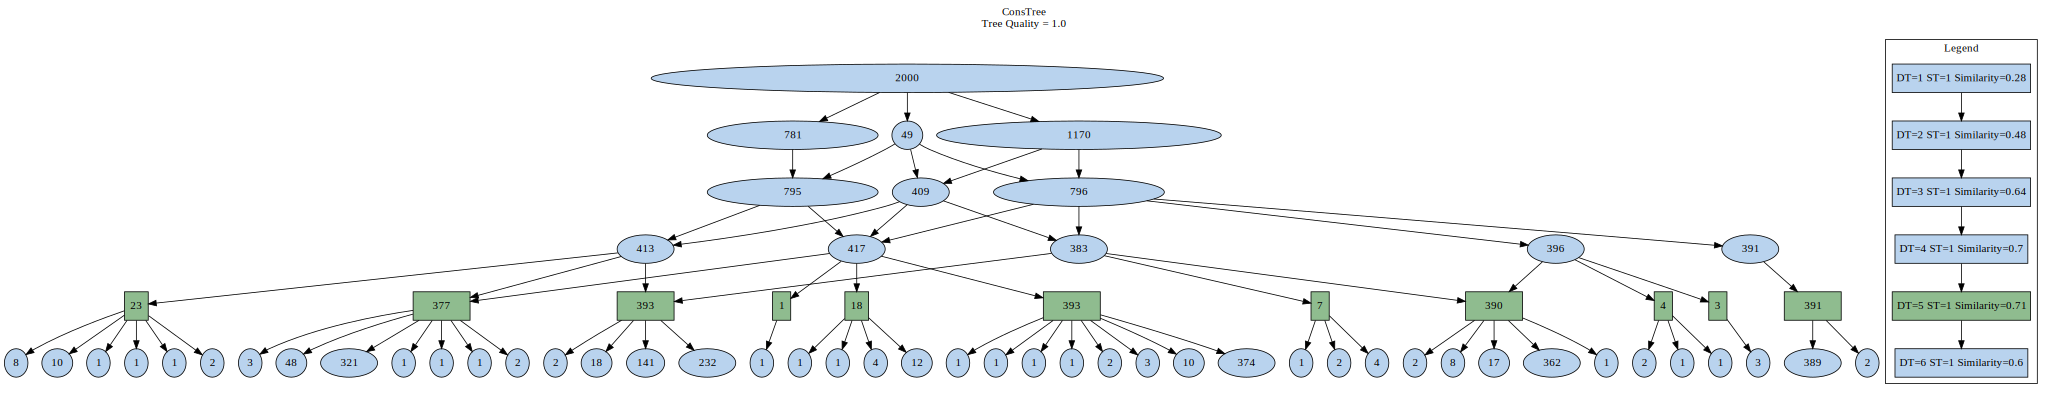

In [26]:
# %% [markdown]
# View ConsTree graph 4 in full size: [GaussianConsTree4.svg](../GaussianConsTree4.svg)

# %%
cons_tree = consensus_5.cons_tree()
# Save the ConsTree graph to a file
cons_tree.render(outfile=f"{file_prefix}GaussianConsTree5.svg", cleanup=True)
cons_tree

In [27]:
# %% [markdown]
# View ConsTree graph 5 in full size: [GaussianConsTree5.svg](../GaussianConsTree5.svg)

# %% [markdown]
# **Finally, let's compare the clustering results:**

# %%
true_labels = gaussian_distributions["class"].to_numpy()
# We compare the results using the pair-wise Jaccard Similarity Measure
pd.DataFrame(
    [
        ["K-means", jaccard_similarity(base_clusterings[0], true_labels)],
        ["Average linkage", jaccard_similarity(base_clusterings[1], true_labels)],
        ["Gaussian model", jaccard_similarity(base_clusterings[2], true_labels)],
        ["C-means", jaccard_similarity(base_clusterings[3], true_labels)],
        ["PAM", jaccard_similarity(base_clusterings[4], true_labels)],
        ["BIRCH", jaccard_similarity(base_clusterings[5], true_labels)],
        ["MultiCons_1", jaccard_similarity(consensus_1.labels_, true_labels)],
        ["MultiCons_2", jaccard_similarity(consensus_2.labels_, true_labels)],
        ["MultiCons_3", jaccard_similarity(consensus_3.labels_, true_labels)],
        ["MultiCons_4", jaccard_similarity(consensus_4.labels_, true_labels)],
        ["MultiCons_5", jaccard_similarity(consensus_5.labels_, true_labels)],
    ],
    columns=["Algorithm", "Jaccard"]
)

,Algorithm,Jaccard
0,K-means,0.666273
1,Average linkage,0.886537
2,Gaussian model,0.913323
3,C-means,0.343885
4,PAM,0.528010
5,BIRCH,0.860716
6,MultiCons_1,0.736251
7,MultiCons_2,0.895996
8,MultiCons_3,0.888027
9,MultiCons_4,0.901381
